# Started from here!

In [22]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

import cv2
import numpy as np
from PIL import Image
import os

import heapq
import itertools
from sklearn.decomposition import PCA

In [23]:
test_dir = 'data/merged/test/'
train_dir = 'data/merged/train/'

#b_train_dir = 'data/balanced/'

classes = os.listdir(train_dir)
test_cls = os.listdir(train_dir)
num_classes = len(classes)

In [24]:
print(
    f'Number of classes: {num_classes}',
    f'\nClasses: {classes}'
)

Number of classes: 7 
Classes: ['fear', 'angry', 'sad', 'neutral', 'surprise', 'disgust', 'happy']


In [25]:
print("--------Train--------")
# check the number of images in each class
for cls in classes:
    print(f'{cls}: {len(os.listdir(train_dir + cls))}')

print("\n--------Test--------")
# check the number of images in each class
for cls in classes:
    print(f'{cls}: {len(os.listdir(test_dir + cls))}')
    
#print("\n--------balance--------")
## check the number of images in each class
#for cls in classes:
#    print(f'{cls}: {len(os.listdir(b_train_dir + cls))}')

--------Train--------
fear: 5000
angry: 5000
sad: 5000
neutral: 5000
surprise: 5000
disgust: 5000
happy: 7215

--------Test--------
fear: 1024
angry: 1000
sad: 1247
neutral: 1233
surprise: 1000
disgust: 1000
happy: 1774


In [26]:
import os
import imghdr
import shutil

def delete_irrelevant_files(directory, classes):
    for cls in classes:
        class_dir = os.path.join(directory, cls)
        with os.scandir(class_dir) as entries:
            for entry in entries:
                # Delete directories
                if entry.is_dir():
                    print(f'Deleting directory: {entry.path}')
                    shutil.rmtree(entry.path)

                # Check if the file is empty and delete it
                elif os.path.getsize(entry.path) == 0:
                    print(f'Deleting empty file: {entry.path}')
                    os.remove(entry.path)

                # Check if the file is not an image and delete it
                elif not imghdr.what(entry.path):
                    print(f'Deleting non-image file: {entry.path}')
                    os.remove(entry.path)

print("--------Train--------")
delete_irrelevant_files(train_dir, classes)

print("\n--------Test--------")
delete_irrelevant_files(test_dir, classes)

#delete_irrelevant_files(b_train_dir, classes)


--------Train--------

--------Test--------


# Landmark detection from images and correlation of those landmark positions

In [27]:
image_size = torch.Size([48, 48, 3])
batch_size = 256

# Compute the total size of the image input
image_input_size = np.prod(image_size) * batch_size * 4. / (1024 ** 2.)
print(f"Image input size: {image_input_size:.2f} MB")

Image input size: 6.75 MB


In [28]:
class FER_Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []  # new list to store the label index
        for i, label in enumerate(os.listdir(root_dir)):
            class_dir = os.path.join(root_dir, label)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                image = cv2.imread(img_path)
                self.data.append(image)
                self.labels.append(i)  # add the label index for this image

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]  # get the label index for this image

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label  # return the image and label index

In [29]:
# Train the model
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = FER_Dataset(train_dir, transform=transform)
val_dataset = FER_Dataset(test_dir, transform=transform)

In [30]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=24)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=24)

In [31]:
# show shape of the train_dataloader
for i, data in enumerate(train_dataloader):
    print(i, data[0].shape, data[1].shape)
    break

# show shape of the val_dataloader
for i, data in enumerate(val_dataloader):
    print(i, data[0].shape, data[1].shape)
    break

# torch.Size([4, 3, 48, 48]) torch.Size([4])
# torch.Size([4, 3, 48, 48]) torch.Size([4])

# 0 torch.Size([256, 3, 64, 64]) torch.Size([256])
# 0 torch.Size([256, 3, 64, 64]) torch.Size([256])

0 torch.Size([256, 3, 64, 64]) torch.Size([256])
0 torch.Size([256, 3, 64, 64]) torch.Size([256])


In [32]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads

        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)

        self.fc = nn.Linear(input_dim, input_dim)

    def scaled_dot_product_attention(self, query, key, value):
        qk = torch.matmul(query, key.transpose(-2, -1))
        dk = query.size(-1)
        scaled_attention_logits = qk / torch.sqrt(torch.tensor(dk, dtype=torch.float32, device=qk.device))

        attention_weights = F.softmax(scaled_attention_logits, dim=-1)
        output = torch.matmul(attention_weights, value)
        return output, attention_weights

    def split_heads(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1, self.num_heads, self.head_dim)
        return x.transpose(1, 2)

    def forward(self, x):
        batch_size = x.size(0)

        query = self.query(x)
        key = self.key(x)
        value = self.value(x)

        query = self.split_heads(query)
        key = self.split_heads(key)
        value = self.split_heads(value)

        out, attention_weights = self.scaled_dot_product_attention(query, key, value)
        out = out.transpose(1, 2).contiguous().view(batch_size, -1, self.input_dim)

        out = self.fc(out)
        
        return out

In [39]:
class FacialExpressionDetectionModel(nn.Module):
    def __init__(self, num_classes, num_heads):
        super(FacialExpressionDetectionModel, self).__init__()
        
        # Load pre-trained MobileNetV2 model
        mobilenet_v2 = models.mobilenet_v2(weights=True)
        mobilenet_features = mobilenet_v2.features

        # Freeze the first three blocks of the MobileNetV2 model
        for param in mobilenet_features[:18].parameters():
            param.requires_grad = False

        self.conv1 = nn.Sequential(
            # remaining layers of the mobilenetV2
            mobilenet_features[0],
            mobilenet_features[1],
            mobilenet_features[2],
            # Biases are freezed just like in the François Chollet's Book!
            nn.Conv2d(24, 64, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5)
        )

        # Block-2
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 512, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 256, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5)
        )

        # Block-3
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )

        # Block-4
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 256, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.125)
        )

        # Block-5
        self.fc1 = nn.Sequential(
            nn.Linear(64 * 2 * 2, 512),  # Update the input size to match the new input shape
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.25)
        )

        # Attention Layer
        self.attention = MultiHeadAttention(512, num_heads)
        self.attention_transform = nn.Linear(512, 64)


        # Block-6
        self.fc2 = nn.Sequential(
            nn.Linear(64, 32),  # Update the input size to 64
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(32),
            nn.Dropout(0.125),
        )

        # Block-7
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.attention(x)
        x = x.view(x.size(0), -1)  # Flatten the output of the attention layer
        x = self.attention_transform(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return F.softmax(x, dim=1)


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [41]:
num_classes = 7
num_heads = 32
model = FacialExpressionDetectionModel(num_classes, num_heads).to(device)

In [42]:
with open('FER_model.txt', 'w') as f:
    f.write(str(model))

In [43]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for data, targets in dataloader:
        data = data.to(device)
        targets = targets.to(device)

        # Use autocast for mixed precision
        with autocast():
            outputs = model(data)
            loss = criterion(outputs, targets)
            _, preds = torch.max(outputs, 1)

        # Scale the loss and perform backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * data.size(0)
        running_corrects += torch.sum(preds == targets.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc


In [44]:
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for data, targets in dataloader:
            data, targets = data.to(device), targets.to(device)

            # Use autocast for mixed precision
            with autocast():
                outputs = model(data)
                loss = criterion(outputs, targets)
                _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * data.size(0)
            running_corrects += torch.sum(preds == targets.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc

In [45]:
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = FacialExpressionDetectionModel(num_classes, num_heads).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=0.0001)
scaler = GradScaler()

In [46]:
print(device)

cuda


In [47]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [48]:
import matplotlib.pyplot as plt

# create empty lists to store loss and accuracy for each epoch
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

num_epochs = 70
for epoch in range(num_epochs):
    
    train_loss, train_acc = train_epoch(model, train_dataloader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_dataloader, criterion, device)
    scheduler.step(val_loss)
    
    # append the loss and accuracy to the lists
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)


    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch: 1/70, Train Loss: 1.7618, Train Acc: 0.3984, Val Loss: 1.6655, Val Acc: 0.4928
Epoch: 2/70, Train Loss: 1.6786, Train Acc: 0.4846, Val Loss: 1.6744, Val Acc: 0.4837
Epoch: 3/70, Train Loss: 1.6547, Train Acc: 0.5060, Val Loss: 1.6237, Val Acc: 0.5379
Epoch: 4/70, Train Loss: 1.6451, Train Acc: 0.5162, Val Loss: 1.5951, Val Acc: 0.5663
Epoch: 5/70, Train Loss: 1.6232, Train Acc: 0.5387, Val Loss: 1.5954, Val Acc: 0.5655
Epoch: 6/70, Train Loss: 1.6228, Train Acc: 0.5394, Val Loss: 1.6053, Val Acc: 0.5556
Epoch: 7/70, Train Loss: 1.6107, Train Acc: 0.5512, Val Loss: 1.5809, Val Acc: 0.5808
Epoch: 8/70, Train Loss: 1.6039, Train Acc: 0.5592, Val Loss: 1.5830, Val Acc: 0.5778
Epoch: 9/70, Train Loss: 1.6030, Train Acc: 0.5596, Val Loss: 1.5729, Val Acc: 0.5900
Epoch: 10/70, Train Loss: 1.5961, Train Acc: 0.5660, Val Loss: 1.5719, Val Acc: 0.5901
Epoch: 11/70, Train Loss: 1.5885, Train Acc: 0.5740, Val Loss: 1.5746, Val Acc: 0.5875
Epoch: 12/70, Train Loss: 1.5874, Train Acc: 0.5752,

In [49]:
import torch
import torch.onnx

device = next(model.parameters()).device
dummy_input = torch.randn(1, 3, 64, 64).to(device)

onnx_filename = "FER_Model_AdamW.onnx"
torch.onnx.export(model, dummy_input, onnx_filename)

print(f"Model saved as {onnx_filename}")

<ipython-input-32-874faf80d163>:17: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  scaled_attention_logits = qk / torch.sqrt(torch.tensor(dk, dtype=torch.float32, device=qk.device))
<ipython-input-32-874faf80d163>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scaled_attention_logits = qk / torch.sqrt(torch.tensor(dk, dtype=torch.float32, device=qk.device))


Model saved as FER_Model_AdamW.onnx


/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


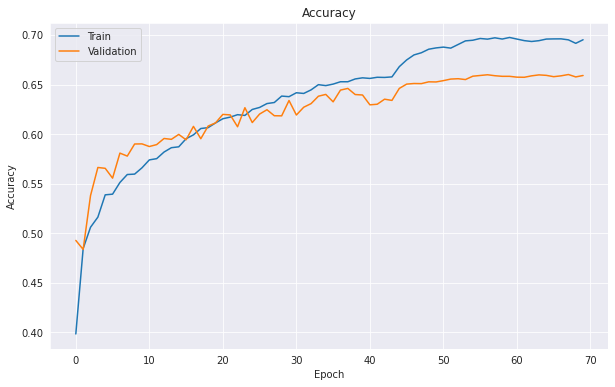

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

train_acc_list = [float(t) for t in train_acc_list]
val_acc_list = [float(t) for t in val_acc_list]

train_acc_df = pd.DataFrame({'Epoch': range(len(train_acc_list)), 'Accuracy': train_acc_list, 'Type': 'Train'})
val_acc_df = pd.DataFrame({'Epoch': range(len(val_acc_list)), 'Accuracy': val_acc_list, 'Type': 'Validation'})

acc_df = pd.concat([train_acc_df, val_acc_df])

sns.set_style('darkgrid')

plt.figure(figsize=(10, 6))
sns.lineplot(data=acc_df, x='Epoch', y='Accuracy', hue='Type')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Save the graph to a file
plt.savefig('accuracy_graph_AdamW.png', dpi=300)

plt.show()


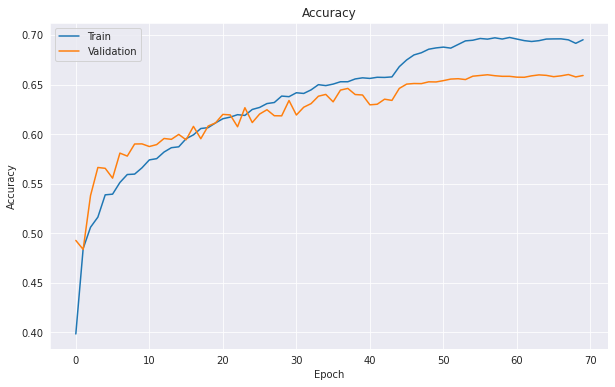

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

train_acc_list = [float(t) for t in train_acc_list]
val_acc_list = [float(t) for t in val_acc_list]

train_acc_df = pd.DataFrame({'Epoch': range(len(train_acc_list)), 'Accuracy': train_acc_list, 'Type': 'Train'})
val_acc_df = pd.DataFrame({'Epoch': range(len(val_acc_list)), 'Accuracy': val_acc_list, 'Type': 'Validation'})

acc_df = pd.concat([train_acc_df, val_acc_df])

sns.set_style('darkgrid')

plt.figure(figsize=(10, 6))
sns.lineplot(data=acc_df, x='Epoch', y='Accuracy', hue='Type')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Save the graph to a file
plt.savefig('accuracy_graph_AdamW.png', dpi=300)

plt.show()


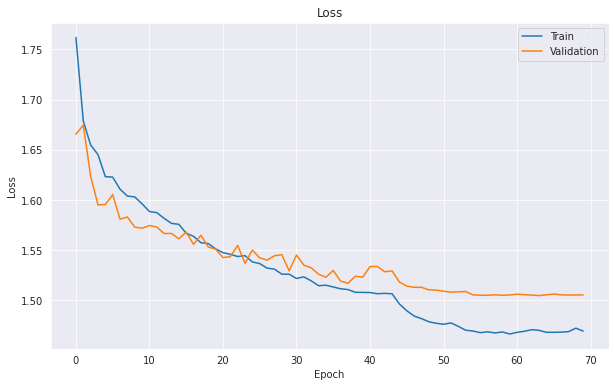

In [52]:
train_loss_list = [float(t) for t in train_loss_list]
val_loss_list = [float(t) for t in val_loss_list]

train_loss_list = pd.DataFrame({'Epoch': range(len(train_loss_list)), 'Loss': train_loss_list, 'Type': 'Train'})
val_loss_list = pd.DataFrame({'Epoch': range(len(val_loss_list)), 'Loss': val_loss_list, 'Type': 'Validation'})

acc_df = pd.concat([train_loss_list, val_loss_list])

sns.set_style('darkgrid')

plt.figure(figsize=(10, 6))
sns.lineplot(data=acc_df, x='Epoch', y='Loss', hue='Type')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save the graph to a file
plt.savefig('loss_graph_AdamW.png', dpi=300)

plt.show()


In [53]:
# define a function to check pytorch version
def check_pytorch_version():
    if torch.__version__ >= '1.6.0':
        return True
    else:
        return False
    
# define a function to check cuda version
def check_cuda_version():
    if torch.cuda.is_available():
        return True
    else:
        return False
    
# define a function to check cudnn version
def check_cudnn_version():
    if check_cuda_version():
        if torch.backends.cudnn.enabled:
            return True
        else:
            return False
    else:
        return False
    
# define a function to check if the system is ready for training
def check_system():
    if check_pytorch_version():
        print('PyTorch version: {}'.format(torch.__version__))
    else:
        print('PyTorch version: {} (update required)'.format(torch.__version__))
        
    if check_cuda_version():
        print('CUDA version: {}'.format(torch.version.cuda))
    else:
        print('CUDA version: {} (install CUDA to enable GPU training)'.format(torch.version.cuda))
        
    if check_cudnn_version():
        print('cuDNN version: {}'.format(torch.backends.cudnn.version()))
    else:
        print('cuDNN version: {} (install cuDNN to enable GPU training)'.format(torch.backends.cudnn.version()))

check_system()

PyTorch version: 1.12.1
CUDA version: 11.6
cuDNN version: 8303
